In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Читаем подготовленные данные
data = pd.read_csv('data/mental_health_data_expanded.csv')

In [4]:
def plot_importance(importance, title=''):
    plt.figure(figsize=(10, 5))
    plt.bar([item[0] for item in importance], [item[1] for item in importance])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def print_metrics(acc, prec, rec, f1):
    print(f'Accuracy: {acc:.2f}')
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f'F1: {f1:.2f}')

# TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
# Создаем TF-IDF векторизатор
vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),   # учитывать только отдельные слова (1-граммы)
    max_features=2000,     # ограничить количество фичей
    min_df=2,
    max_df=0.8
)

# Применяем TF-IDF к текстам людей
tfidf_matrix = vectorizer.fit_transform(data['cleaned_text'].to_list())

# Преобразуем в DataFrame
tfidf_features = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)

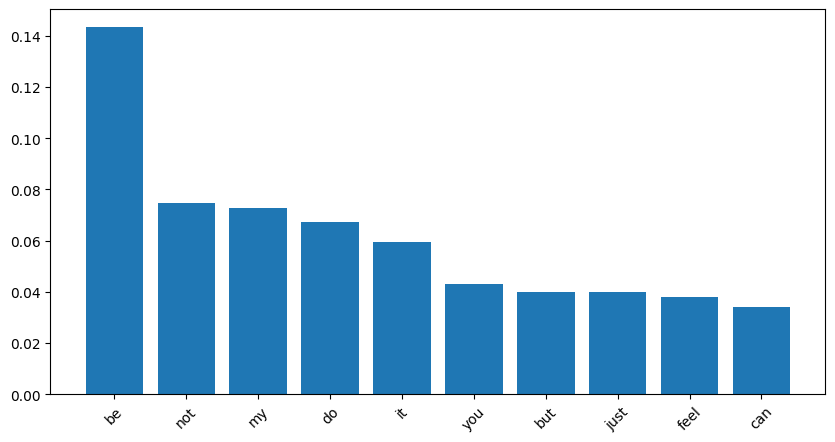

In [11]:
# Получаем веса слов (среднее значение по всем текстовым заметкам)
word_weights = tfidf_matrix.mean(axis=0).tolist()[0]
words = vectorizer.get_feature_names_out()

# Сортируем слова по важности
word_importance = sorted(zip(words, word_weights), key=lambda x: x[1], reverse=True)[:10]

plot_importance(word_importance)

## Random Forest

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
# Собираем данные в одну кучу
ohe = OneHotEncoder()
categorial_features = pd.DataFrame(
    ohe.fit_transform(data[['top_emotion']]).toarray(),
    columns=ohe.get_feature_names_out()
)
numerical_features = data.drop(columns=['statement', 'cleaned_text', 'top_emotion']).copy()
total_features = pd.concat([categorial_features, numerical_features, tfidf_features], axis=1)

binary_target = total_features['at_risk'].copy()
multiclass_target = total_features['status'].copy()
total_features = total_features.drop(columns=['at_risk', 'status'])

### Бинарная классификация

In [14]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    total_features, binary_target, test_size=0.2, random_state=42
)

# Обучаем модель бинарной классификации
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Получаем предсказания
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3329
           1       0.94      0.96      0.95      7206

    accuracy                           0.94     10535
   macro avg       0.93      0.92      0.93     10535
weighted avg       0.94      0.94      0.94     10535



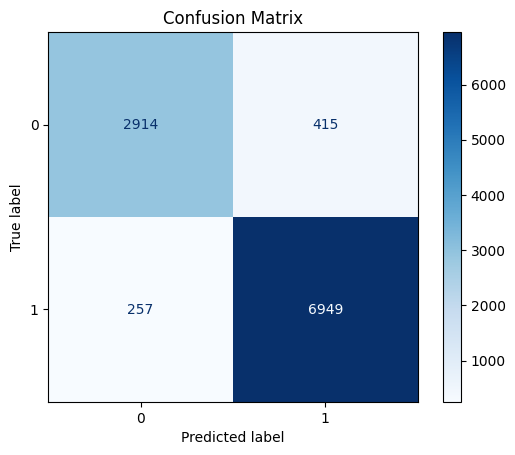

In [15]:
# Оцениваем метрики
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Модель достигла хорошего качества в определении рискованного состояния психики.

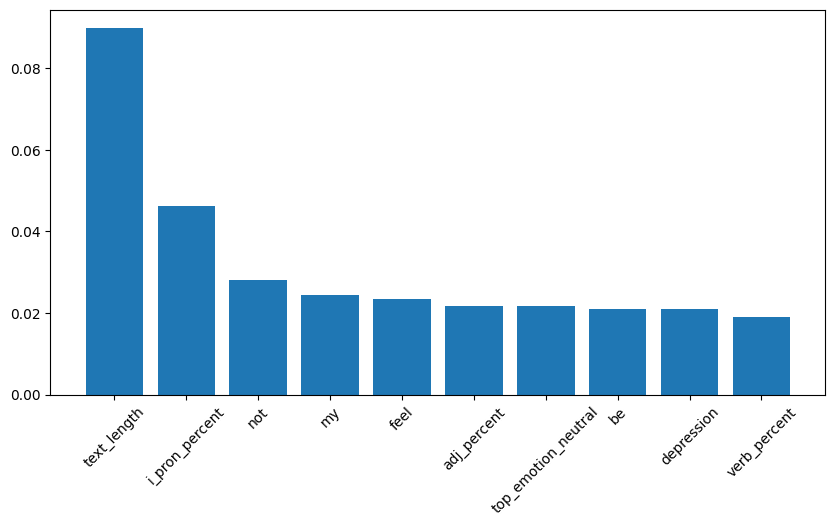

In [16]:
features_importance = sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda x: x[1], reverse=True)[:10]

plot_importance(features_importance)

Одними из самых важных признаков являются длина текста, процент местоимений "I" как показатель саморефлексии, глагол "do", а также другие слова и лингвистические хакартеристики, указывающие на наличие или отсутствие риска. 

### Многоклассовая классификация

In [17]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    total_features, 
    multiclass_target, 
    test_size=0.2, 
    random_state=42,
    stratify=multiclass_target
)

# Обучаем модель классификации
model = RandomForestClassifier(class_weight="balanced")
model.fit(X_train, y_train)

# Получаем предсказания
y_pred = model.predict(X_test)

                      precision    recall  f1-score   support

             Anxiety       0.87      0.61      0.72       768
             Bipolar       0.92      0.60      0.73       556
          Depression       0.58      0.78      0.66      3081
              Normal       0.83      0.93      0.88      3268
Personality disorder       1.00      0.41      0.58       215
              Stress       0.82      0.31      0.45       517
            Suicidal       0.66      0.49      0.56      2130

            accuracy                           0.71     10535
           macro avg       0.81      0.59      0.65     10535
        weighted avg       0.73      0.71      0.70     10535



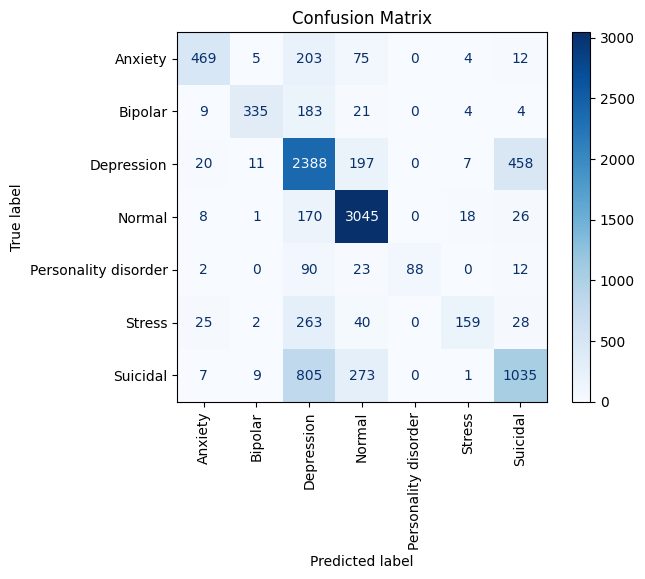

In [18]:
# Оцениваем метрики
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

Есть довольно большие ошибки в определении таких состояний как "Depression" и "Suicidal", а их качественное предсказание очень важно. При это со 100% точностю получилось предсказывать состояние "Personality disorder".

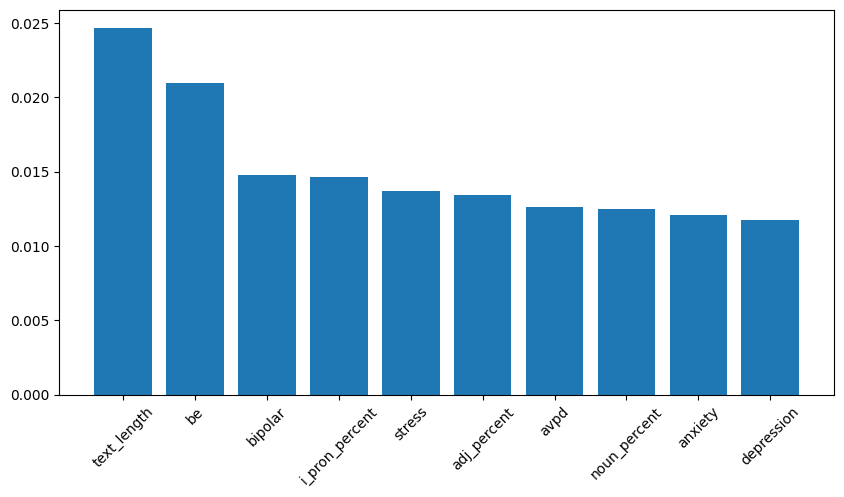

In [19]:
features_importance = sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda x: x[1], reverse=True)[:10]

plot_importance(features_importance)

# Catboost

In [27]:
from catboost import CatBoostClassifier

In [28]:
# Собираем данные в одну кучу
features = data.drop(columns=['statement', 'cleaned_text']).copy()
total_features = pd.concat([features, tfidf_features], axis=1)

binary_target = total_features['at_risk'].copy()
multiclass_target = total_features['status'].copy()
total_features = total_features.drop(columns=['at_risk', 'status'])

## Бинарная классификация

In [29]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    total_features, binary_target, test_size=0.2, random_state=42
)

# Обучаем CatBoostClassifier
model = CatBoostClassifier(
    cat_features=['top_emotion'], iterations=100, 
    depth=6, learning_rate=0.1, verbose=1)
model.fit(X_train, y_train)

# Получаем предсказания
y_pred = model.predict(X_test)

0:	learn: 0.5899107	total: 38.4ms	remaining: 3.8s
1:	learn: 0.5162993	total: 70.8ms	remaining: 3.47s
2:	learn: 0.4528003	total: 103ms	remaining: 3.34s
3:	learn: 0.4090413	total: 133ms	remaining: 3.2s
4:	learn: 0.3727730	total: 166ms	remaining: 3.16s
5:	learn: 0.3381588	total: 197ms	remaining: 3.09s
6:	learn: 0.3166030	total: 228ms	remaining: 3.02s
7:	learn: 0.3014291	total: 259ms	remaining: 2.98s
8:	learn: 0.2880912	total: 289ms	remaining: 2.92s
9:	learn: 0.2762605	total: 321ms	remaining: 2.89s
10:	learn: 0.2672558	total: 354ms	remaining: 2.86s
11:	learn: 0.2605984	total: 384ms	remaining: 2.82s
12:	learn: 0.2550973	total: 414ms	remaining: 2.77s
13:	learn: 0.2490781	total: 444ms	remaining: 2.73s
14:	learn: 0.2425767	total: 476ms	remaining: 2.7s
15:	learn: 0.2382258	total: 509ms	remaining: 2.67s
16:	learn: 0.2350312	total: 538ms	remaining: 2.63s
17:	learn: 0.2320717	total: 567ms	remaining: 2.58s
18:	learn: 0.2283429	total: 600ms	remaining: 2.56s
19:	learn: 0.2254989	total: 633ms	remainin

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3329
           1       0.95      0.95      0.95      7206

    accuracy                           0.94     10535
   macro avg       0.93      0.92      0.93     10535
weighted avg       0.94      0.94      0.94     10535



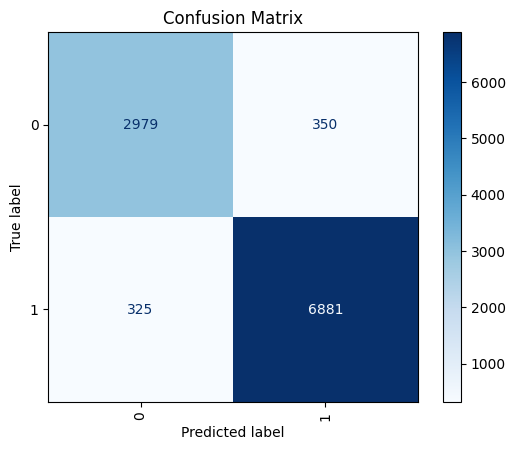

In [30]:
# Оцениваем метрики
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

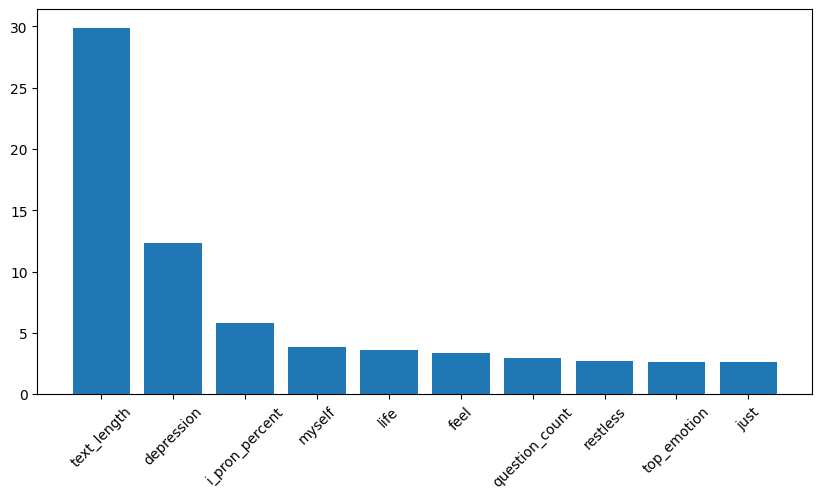

In [31]:
features_importance = sorted(zip(model.feature_names_, model.feature_importances_), key=lambda x: x[1], reverse=True)[:10]

plot_importance(features_importance)

## Многоклассовая классификация

In [32]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    total_features, 
    multiclass_target, 
    test_size=0.2, 
    random_state=42,
    stratify=multiclass_target
)

# Обучаем CatBoostClassifier
model = CatBoostClassifier(
    cat_features=['top_emotion'], iterations=500, depth=6, 
    learning_rate=0.1, loss_function='MultiClass', verbose=1)
model.fit(X_train, y_train)

# Получаем предсказания
y_pred = model.predict(X_test)

0:	learn: 1.7358351	total: 228ms	remaining: 1m 53s
1:	learn: 1.6095866	total: 408ms	remaining: 1m 41s
2:	learn: 1.5201668	total: 576ms	remaining: 1m 35s
3:	learn: 1.4450838	total: 748ms	remaining: 1m 32s
4:	learn: 1.3868102	total: 917ms	remaining: 1m 30s
5:	learn: 1.3378832	total: 1.09s	remaining: 1m 30s
6:	learn: 1.2959282	total: 1.26s	remaining: 1m 29s
7:	learn: 1.2563976	total: 1.44s	remaining: 1m 28s
8:	learn: 1.2244746	total: 1.61s	remaining: 1m 28s
9:	learn: 1.1930350	total: 1.77s	remaining: 1m 26s
10:	learn: 1.1706578	total: 1.93s	remaining: 1m 25s
11:	learn: 1.1489848	total: 2.09s	remaining: 1m 24s
12:	learn: 1.1287893	total: 2.25s	remaining: 1m 24s
13:	learn: 1.1094078	total: 2.41s	remaining: 1m 23s
14:	learn: 1.0909883	total: 2.58s	remaining: 1m 23s
15:	learn: 1.0765055	total: 2.75s	remaining: 1m 23s
16:	learn: 1.0637509	total: 2.9s	remaining: 1m 22s
17:	learn: 1.0522848	total: 3.06s	remaining: 1m 21s
18:	learn: 1.0390156	total: 3.22s	remaining: 1m 21s
19:	learn: 1.0277201	to

                      precision    recall  f1-score   support

             Anxiety       0.79      0.72      0.75       768
             Bipolar       0.89      0.68      0.77       556
          Depression       0.67      0.75      0.71      3081
              Normal       0.85      0.95      0.90      3268
Personality disorder       0.89      0.41      0.56       215
              Stress       0.64      0.37      0.47       517
            Suicidal       0.70      0.62      0.66      2130

            accuracy                           0.76     10535
           macro avg       0.77      0.64      0.69     10535
        weighted avg       0.76      0.76      0.75     10535



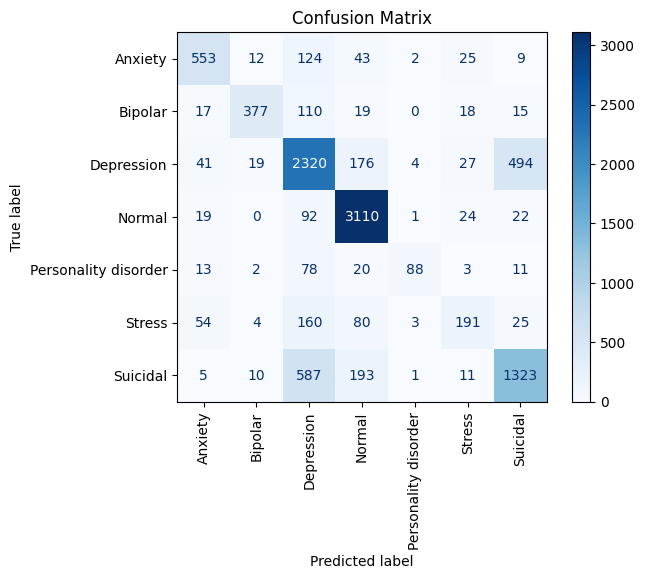

In [33]:
# Оцениваем метрики
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

Метрики по проблемным классам немного лучше, чем в случае модели Random Forest. Также выше метрики recall, f1-score.